In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings

import numpy as np
import matplotlib.pyplot as plt
from agentic_energy.heuristics.heuristic_trader import HeuristicTrader, records_to_arrays
from agentic_energy.data_loader import EnergyDataLoader
from agentic_energy.schemas import BatteryParams, DayInputs, SolveRequest

2025-10-15 15:55:23.579 | DEBUG    | agentics.core.llm_connections:<module>:121 - AGENTICS is connecting to the following LLM API providers:
2025-10-15 15:55:23.579 | DEBUG    | agentics.core.llm_connections:<module>:129 - 0 - Gemini
2025-10-15 15:55:23.579 | DEBUG    | agentics.core.llm_connections:<module>:135 - Please add API keys in .env file to add or disconnect providers.
2025-10-15 15:55:23.587 | DEBUG    | agentics.core.llm_connections:get_llm_provider:29 - No LLM provider specified. Using the first available provider.
2025-10-15 15:55:23.588 | DEBUG    | agentics.core.llm_connections:get_llm_provider:31 - Available LLM providers: ['gemini']. Using 'gemini'


Forecast Engine using device: cpu


In [2]:
italy_obj = EnergyDataLoader(region="ITALY")
italy_data = italy_obj.load_region_data()

2025-10-15 15:55:25.184 | DEBUG    | agentics.core.agentics:from_csv:312 - Importing Agentics of type EnergyDataRecord from CSV /Users/millendroy/Projects/Agentic_Energy/Agentics_for_EnergyArbitrage_Battery/energy_arbitrage/agentic_energy/data/Italy_data.csv


In [3]:
italy_data[0]

EnergyDataRecord(timestamps='2022-01-01 00:00:00', prices=170.28, consumption=22.4, year=None, region='ITALY', decisions=None)

In [4]:
stats= await EnergyDataLoader.get_summary_stats_from_ag(italy_data)
print(stats.pretty_print())

Atype : <class 'agentic_energy.schemas.SummaryStats'>
region: ITALY
total_records: 17516
date_range:
  start: '2022-01-01 00:00:00'
  end: '2023-12-31 23:00:00'
prices:
  count: 17516
  min: 2.46
  max: 870.0
  avg: 215.6138005252341
  median: 175.01
  p25: 119.9175
  p75: 264.4875
  std: 131.54084577611607
  var: 17302.99410749595
consumption:
  count: 17516
  min: 17.49
  max: 49.93
  avg: 31.840349965745602
  median: 31.36
  p25: 26.1
  p75: 37.25
  std: 6.589954117466047
  var: 43.42749527030771




In [5]:
capacity = 1.0  # kWh
batterydetails = BatteryParams(
    capacity_kwh=capacity,   # 4-hour energy at 100 kW power: good for diurnal spreads
    soc_init=0.50,        # neutral start
    soc_min=0.0,         # keep 10% buffer for longevity + contingency
    soc_max=1.0,         # avoid top-of-charge stress
    cmax_kw=capacity/4,        # 4-hour duration (capacity/4)
    dmax_kw=capacity/4,        # symmetric charge/discharge
    eta_c=0.95,           # ~92% round-trip when paired with eta_d
    eta_d=0.95,
    soc_target=0.50       # keep headroom to buy when prices dip; adjust by time-of-day policy
)

In [6]:
trader_time = HeuristicTrader(
        mode="time",
        charge_windows=[(2, 6), (10, 16), (20, 22)],
        discharge_windows=[(0, 2), (6, 10), (16, 20), (22, 24)],
    )
trader_quant = HeuristicTrader(
        mode="quantile",
        low_q=0.30,
        high_q=0.70,
    )

In [7]:
results_time = []
day_info_time = []
decision_list_time = []
soc_list_time = []
num_days = len(italy_data) // 24
bat_time = batterydetails.copy(deep=True)
for i in range(num_days):
        print(f"[TIME] Solving day {i+1}/{num_days}")
        day_records = italy_data[i * 24 : (i + 1) * 24]
        prices, demand = records_to_arrays(day_records)
        day = DayInputs(
            prices_buy=prices,
            prices_sell=prices,
            demand_kw=demand,
            allow_export=True,
            dt_hours=1.0,
        )

        day_info_time.append(day)

        req=SolveRequest(
            battery=bat_time,
            day = day,
            solver = None,
            solver_opts={"mode": "time"},
        )

        result = trader_time.solve(req)
        results_time.append(result)

        # Stitch SoC: use last SoC (fractional) from the day as next day's init
        if result.soc and len(result.soc) > 0:
            # Avoid duplicating the last point in per-step ladders
            soc_list_time += result.soc[:-1]
            bat_time.soc_init = float(result.soc[-1])
        else:
            # If solver returned empty SoC (shouldn't happen), keep previous init
            pass

        # Accumulate decisions
        if result.decision:
            decision_list_time += result.decision

        # Optional: show day summary
        print(f"  Objective cost (day {i+1}): {result.objective_cost:.4f}")

total_cost_time = float(np.nansum([r.objective_cost for r in results_time]))
print(f"=== TIME windows summary ===")
print(f"Total objective cost over all days: {total_cost_time:.4f}  (negative = profit)")

[TIME] Solving day 1/729
  Objective cost (day 1): 88563.0967
[TIME] Solving day 2/729
  Objective cost (day 2): 101849.8739
[TIME] Solving day 3/729
  Objective cost (day 3): 154933.9548
[TIME] Solving day 4/729
  Objective cost (day 4): 131566.3656
[TIME] Solving day 5/729
  Objective cost (day 5): 155185.1961
[TIME] Solving day 6/729
  Objective cost (day 6): 150100.0978
[TIME] Solving day 7/729
  Objective cost (day 7): 180443.3484
[TIME] Solving day 8/729
  Objective cost (day 8): 170833.8252
[TIME] Solving day 9/729
  Objective cost (day 9): 142297.8517
[TIME] Solving day 10/729
  Objective cost (day 10): 224202.4102
[TIME] Solving day 11/729
  Objective cost (day 11): 224785.1419
[TIME] Solving day 12/729
  Objective cost (day 12): 216473.0352
[TIME] Solving day 13/729
  Objective cost (day 13): 205371.5450
[TIME] Solving day 14/729
  Objective cost (day 14): 205096.2477
[TIME] Solving day 15/729
  Objective cost (day 15): 162905.7039
[TIME] Solving day 16/729
  Objective cost (

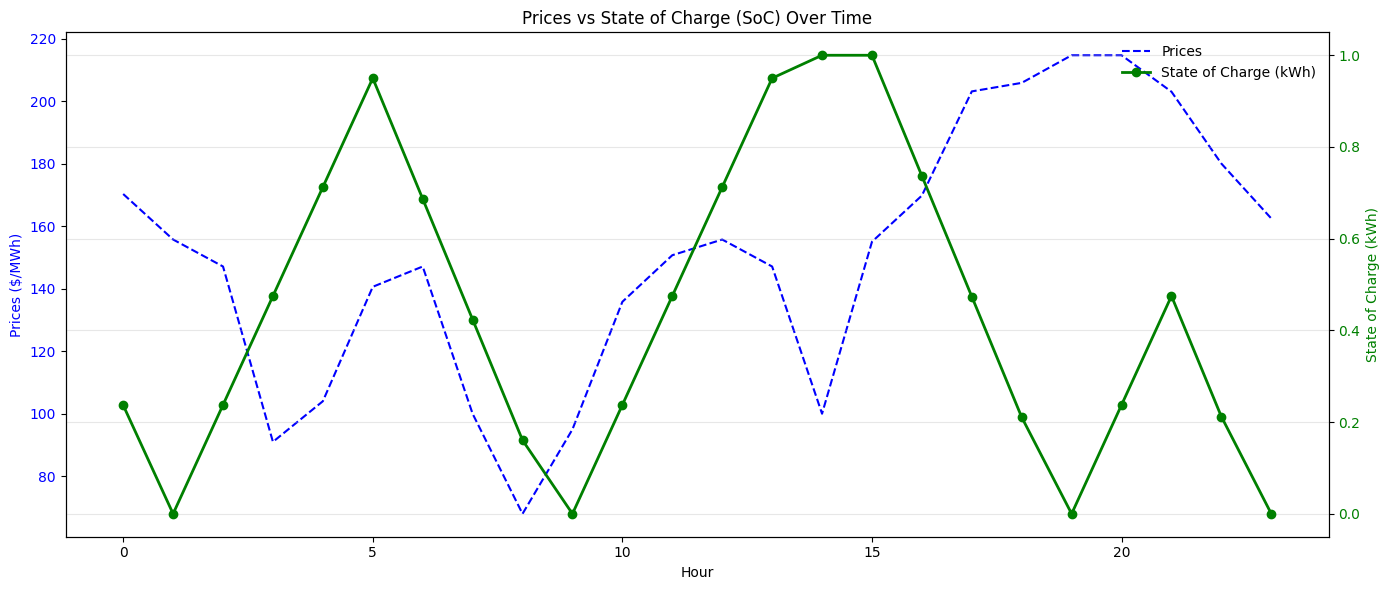

In [13]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, day_info_time[0].prices_buy, '--b', label='Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(results_time[0].soc) * bat_time.capacity_kwh,
         '-og', label='State of Charge (kWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


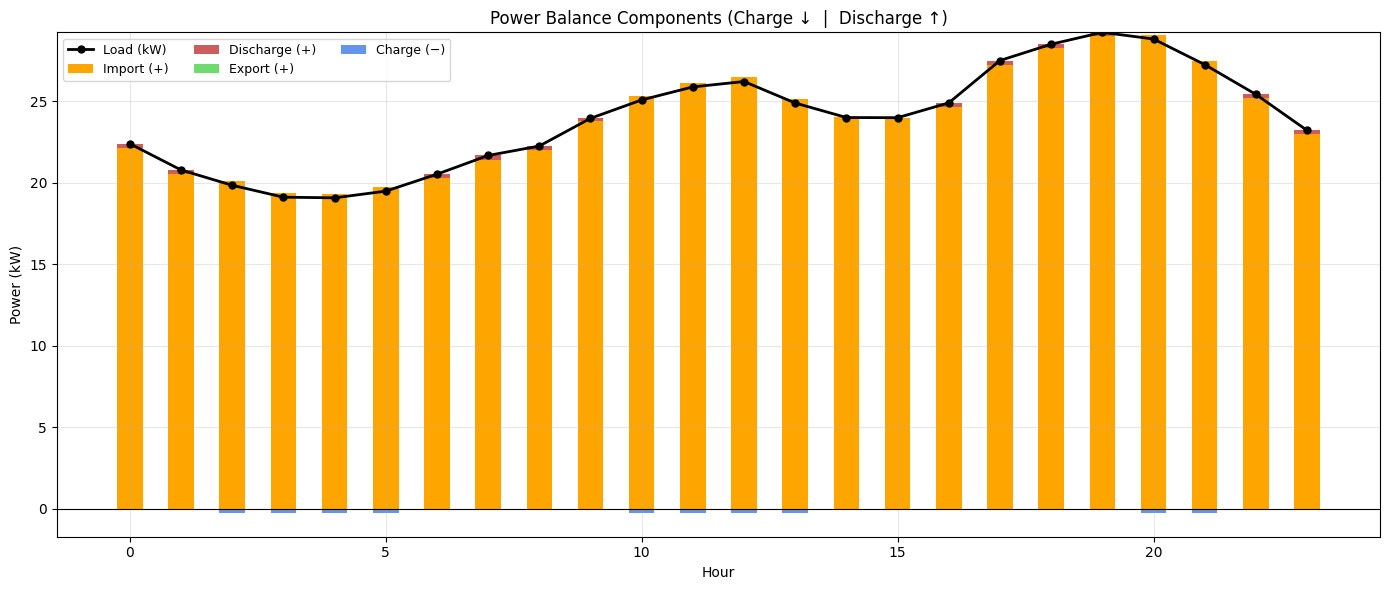

In [14]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)

# Data arrays
load = np.array(day_info_time[0].demand_kw)
charge = np.array(results_time[0].charge_kw)
discharge = np.array(results_time[0].discharge_kw)
import_kw = np.array(results_time[0].import_kw)
export_kw = np.array(results_time[0].export_kw) if getattr(day_info_time[0], "allow_export", False) else np.zeros_like(load)

# Flip battery convention for visualization
charge_vis = -charge       # show charge below 0
discharge_vis = discharge  # show discharge above 0

# ---------------------- PLOT ----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# --- positive side stacking (Import + Discharge + Export) ---
# import is base layer
ax.bar(hours, import_kw, width=0.5, color='orange', label='Import (+)')
# discharge stacked on top of import
ax.bar(hours, discharge_vis, width=0.5, bottom=import_kw, color='indianred', label='Discharge (+)')
# export stacked on top (for clear separation)
ax.bar(hours, export_kw, width=0.5, bottom=import_kw + discharge_vis, color='limegreen', alpha=0.7, label='Export (+)')

# --- negative side stacking (Charge only) ---
ax.bar(hours, charge_vis, width=0.5, color='cornflowerblue', label='Charge (−)')

# --- Load as line ---
ax.plot(hours, load, '-ok', linewidth=2, markersize=5, label='Load (kW)')

# Formatting
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Power (kW)")
ax.set_xlabel("Hour")
ax.set_title("Power Balance Components (Charge ↓  |  Discharge ↑)")
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [15]:
results_quantile = []
day_info_quantile = []
decision_list_quantile = []
soc_list_quantile = []
num_days = len(italy_data) // 24
bat_quantile = batterydetails.copy(deep=True)
for i in range(num_days):
        print(f"[TIME] Solving day {i+1}/{num_days}")
        day_records = italy_data[i * 24 : (i + 1) * 24]
        prices, demand = records_to_arrays(day_records)
        day = DayInputs(
            prices_buy=prices,
            prices_sell=prices,
            demand_kw=demand,
            allow_export=True,
            dt_hours=1.0,
        )

        day_info_quantile.append(day)

        req=SolveRequest(
            battery=bat_quantile,
            day = day,
            solver = None,
            solver_opts={"mode": "quantile"},
        )

        result = trader_quant.solve(req)
        results_quantile.append(result)

        # Stitch SoC: use last SoC (fractional) from the day as next day's init
        if result.soc and len(result.soc) > 0:
            # Avoid duplicating the last point in per-step ladders
            soc_list_quantile += result.soc[:-1]
            bat_quantile.soc_init = float(result.soc[-1])
        else:
            # If solver returned empty SoC (shouldn't happen), keep previous init
            pass

        # Accumulate decisions
        if result.decision:
            decision_list_quantile += result.decision

        # Optional: show day summary
        print(f"  Objective cost (day {i+1}): {result.objective_cost:.4f}")

total_cost_quantile = float(np.nansum([r.objective_cost for r in results_quantile]))
print(f"=== Quantile windows summary ===")
print(f"Total objective cost over all days: {total_cost_quantile:.4f}  (negative = profit)")

[TIME] Solving day 1/729
  Objective cost (day 1): 88457.5546
[TIME] Solving day 2/729
  Objective cost (day 2): 101826.7069
[TIME] Solving day 3/729
  Objective cost (day 3): 154923.2485
[TIME] Solving day 4/729
  Objective cost (day 4): 131558.8129
[TIME] Solving day 5/729
  Objective cost (day 5): 155146.4958
[TIME] Solving day 6/729
  Objective cost (day 6): 150074.9381
[TIME] Solving day 7/729
  Objective cost (day 7): 180456.5244
[TIME] Solving day 8/729
  Objective cost (day 8): 170737.3560
[TIME] Solving day 9/729
  Objective cost (day 9): 142234.7140
[TIME] Solving day 10/729
  Objective cost (day 10): 224189.2691
[TIME] Solving day 11/729
  Objective cost (day 11): 224763.9857
[TIME] Solving day 12/729
  Objective cost (day 12): 216451.0301
[TIME] Solving day 13/729
  Objective cost (day 13): 205290.9807
[TIME] Solving day 14/729
  Objective cost (day 14): 205126.6251
[TIME] Solving day 15/729
  Objective cost (day 15): 162830.5757
[TIME] Solving day 16/729
  Objective cost (

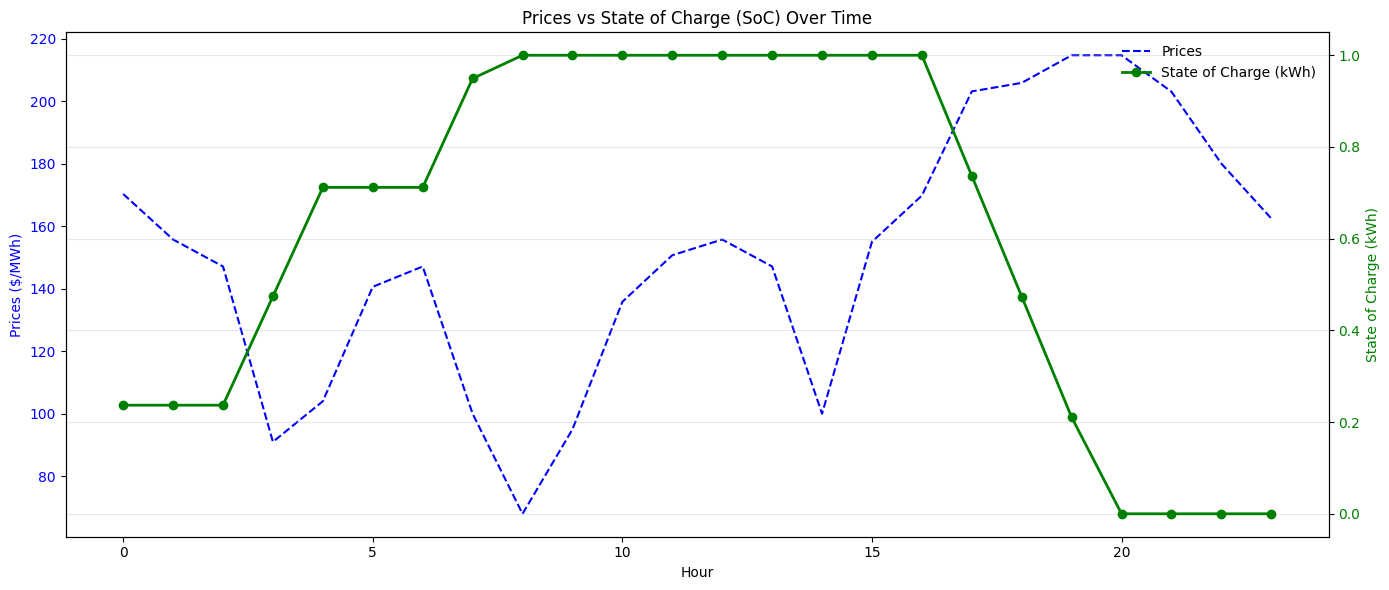

In [16]:
hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, day_info_quantile[0].prices_buy, '--b', label='Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(results_quantile[0].soc) * bat_quantile.capacity_kwh,
         '-og', label='State of Charge (kWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
results_quantile[0].objective_cost, results_time[0].objective_cost

(88457.55460554016, 88563.09670789473)

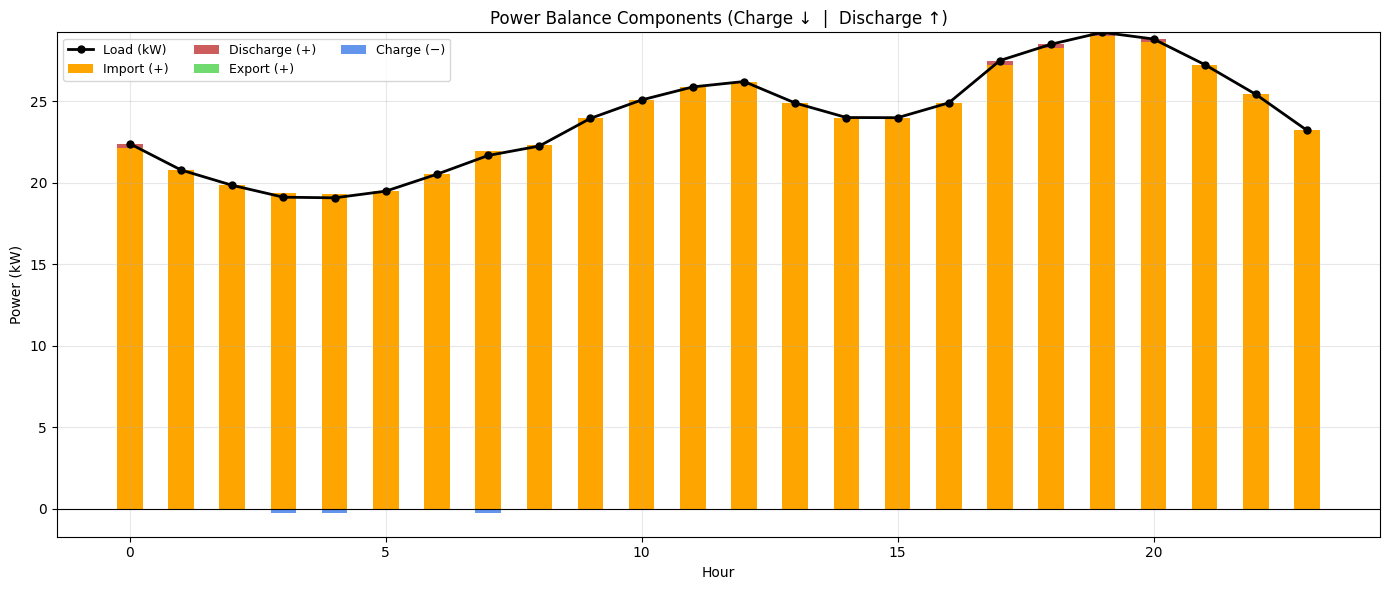

In [17]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)

# Data arrays
load = np.array(day_info_quantile[0].demand_kw)
charge = np.array(results_quantile[0].charge_kw)
discharge = np.array(results_quantile[0].discharge_kw)
import_kw = np.array(results_quantile[0].import_kw)
export_kw = np.array(results_quantile[0].export_kw) if getattr(day_info_quantile[0], "allow_export", False) else np.zeros_like(load)

# Flip battery convention for visualization
charge_vis = -charge       # show charge below 0
discharge_vis = discharge  # show discharge above 0

# ---------------------- PLOT ----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# --- positive side stacking (Import + Discharge + Export) ---
# import is base layer
ax.bar(hours, import_kw, width=0.5, color='orange', label='Import (+)')
# discharge stacked on top of import
ax.bar(hours, discharge_vis, width=0.5, bottom=import_kw, color='indianred', label='Discharge (+)')
# export stacked on top (for clear separation)
ax.bar(hours, export_kw, width=0.5, bottom=import_kw + discharge_vis, color='limegreen', alpha=0.7, label='Export (+)')

# --- negative side stacking (Charge only) ---
ax.bar(hours, charge_vis, width=0.5, color='cornflowerblue', label='Charge (−)')

# --- Load as line ---
ax.plot(hours, load, '-ok', linewidth=2, markersize=5, label='Load (kW)')

# Formatting
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Power (kW)")
ax.set_xlabel("Hour")
ax.set_title("Power Balance Components (Charge ↓  |  Discharge ↑)")
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
